In [1]:
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST

In [2]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
mnist_x_train, mnist_y_train = mndata.load_training()
mnist_x_test, mnist_y_test = mndata.load_testing()

In [3]:
x_train = nn.Tensor(list(mnist_x_train))
x_test = nn.Tensor(list(mnist_x_test))
y_train = nn.Tensor(list(mnist_y_train))
y_test = nn.Tensor(list(mnist_y_test))

In [4]:
rng = np.random.default_rng(seed=1)

In [5]:
# Scale down pixels from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

# OneHot label vectors
def onehot(vector):
    tmp = []
    for scalar in vector.data:
        tmp2 = [1 if i==scalar else 0 for i in range(10)]
        tmp.append(tmp2)
    return nn.Tensor(tmp)
y_train = onehot(y_train)
y_test = onehot(y_test)

print(f'x_train={x_train.shape}, y_train={y_train.shape}')
print(f'x_test={x_test.shape}, y_test={y_test.shape}')

x_train=(60000, 784), y_train=(60000, 10)
x_test=(10000, 784), y_test=(10000, 10)


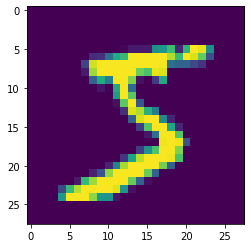

In [6]:
# Visualize X
img = np.array(x_train[0].tolist())
plt.imshow(img.reshape(28, 28))
plt.show()

In [34]:
W = nn.Tensor(rng.normal(size=(784, 200)))
W2 = nn.Tensor(rng.normal(size=(200, 100)))
W3 = nn.Tensor(rng.normal(size=(100, 50)))
b = nn.Tensor(rng.normal(size=(200,)))
b2 = nn.Tensor(rng.normal(size=(100,)))
b3 = nn.Tensor(rng.normal(size=(50,)))
O = nn.Tensor(rng.normal(size=(50, 10)))
parameters = [W,W2,W3,b,b2,b3,O]
losses = []

In [8]:
# Multinomial sampling with replacement
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * x_train.shape[0])
    batch = [draw() for _ in range(batch_size)]
    return x_train[batch], y_train[batch]

In [9]:
def forward(x):
    # L1
    x = b + (x@W) # l1
    x = x.tanh()
    x = b2 + (x@W2)
    x = x.tanh()
    x = b3 + (x@W3)
    x = x.tanh()
    # Output with softmax
    x = x@O
    x = x.exp()

    return x / x.sum(axis=x.dim-1).reshape((-1, 1))

In [52]:
epochs = 20
batch_size = 1000
lr = 0.1
for e in range(epochs):
    x, y = draw_batch(batch_size)

    # Forward
    out = forward(x)

    # Predictions
    y_pred = out*y
    
    # Loss
    maximum_likelihood = (y*y_pred).sum(axis=1)
    neg_log_loss = -1 * maximum_likelihood.log()
    nll = neg_log_loss.sum() 
    loss = nll / batch_size
    losses.append(loss.data.item())
    print(f'Epoch {e}: {loss.data.item()}')

    # Compute gradients
    loss.grad = np.array([1])
    loss.backward()
    
    # Learn
    for p in parameters:
        p.data -= lr * p.grad
        p.grad = np.zeros(p.shape)

Epoch 0: 2.9053389698443692
Epoch 1: 2.9665444324940573
Epoch 2: 2.974661501343075
Epoch 3: 3.096059124942658
Epoch 4: 2.9909931880497598
Epoch 5: 2.9051473619648345
Epoch 6: 3.0434089988979287
Epoch 7: 2.950546563950791
Epoch 8: 2.9340813276829354
Epoch 9: 2.980045807550522
Epoch 10: 2.785994723623082
Epoch 11: 2.940036659956252
Epoch 12: 2.8454774709371886
Epoch 13: 2.7518769662113867
Epoch 14: 2.8925616206645883
Epoch 15: 3.031544090949765
Epoch 16: 2.8804147708777954
Epoch 17: 2.9559391367555055
Epoch 18: 2.8744003824594455
Epoch 19: 2.8705555605749367


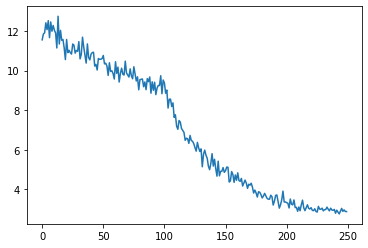

In [53]:
plt.plot(losses)
plt.show()

In [54]:
correct = 0
for i in range(len(x_test.data)):
    y = y_test[i]
    x = forward(x_test[i])
    corr = np.argmax(y.data)
    predicted = np.argmax(x.data)
    if predicted == corr: correct += 1

print(f'Test accuracy: {correct/len(x_test.data)}')

Test accuracy: 0.4526
